# Employee Churn Analysis

### Purpose
- This notebook explores employee behavior and store data from a cleaned dataset.

### Highlights
1. Churn Rate By Department (Pandas)
    - Which departments are struggling the most with employee retention?

2. Tenure vs Churn (Pandas)
    - Which stores have the highest proportion of short, medium, and long tenure employees, and how does tenure relate to overall churn?
    - Tenure Categories
        - Short Service: < 2 years
        - Medium Service: 2–5 years
        - Long Service: > 5 years

3. Churn By Demographics (Pandas)
    - Which gender shows higher churn rates per store?
 

## Setup

In [141]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath(".."))
from etl import get_engine

# Create sqlalchemy engine
engine = get_engine()

# Visuals setup
sns.set_style('white')

# Load tables into dataframes
employee_df: pd.DataFrame = pd.read_sql('SELECT * FROM employees', engine)
store_df: pd.DataFrame = pd.read_sql('SELECT * FROM store', engine)

# Merge tables into a base dataframe
df: pd.DataFrame = employee_df.merge(store_df, on='store_id', how='left').sort_values(['employee_id', 'snapshot_record_date'])
df.head(10)


,employee_id,snapshot_record_date,date_hired,date_terminated,age,years_employed,job_title,store_id,gender,status_year,employee_status,city,department
0,1318,12/31/2006,8/28/1989,None,52,17,CEO,35,Male,2006,ACTIVE,Vancouver,Executive
1,1318,12/31/2007,8/28/1989,None,53,18,CEO,35,Male,2007,ACTIVE,Vancouver,Executive
2,1318,12/31/2008,8/28/1989,None,54,19,CEO,35,Male,2008,ACTIVE,Vancouver,Executive
3,1318,12/31/2009,8/28/1989,None,55,20,CEO,35,Male,2009,ACTIVE,Vancouver,Executive
4,1318,12/31/2010,8/28/1989,None,56,21,CEO,35,Male,2010,ACTIVE,Vancouver,Executive
5,1318,12/31/2011,8/28/1989,None,57,22,CEO,35,Male,2011,ACTIVE,Vancouver,Executive
6,1318,12/31/2012,8/28/1989,None,58,23,CEO,35,Male,2012,ACTIVE,Vancouver,Executive
7,1318,12/31/2013,8/28/1989,None,59,24,CEO,35,Male,2013,ACTIVE,Vancouver,Executive
8,1318,12/31/2014,8/28/1989,None,60,25,CEO,35,Male,2014,ACTIVE,Vancouver,Executive
9,1318,12/31/2015,8/28/1989,None,61,26,CEO,35,Male,2015,ACTIVE,Vancouver,Executive


____________________

## 1. Churn Rate By Department (Pandas)
- Which departments are struggling the most with employee retention?

### Analysis

In [4]:
# Copy to preserve original dataframe
department_copy = df.copy()

# Filter for needed columns 
department_df: pd.DataFrame = department_copy.filter(items=['employee_id', 'employee_status', 'department'])

# Total number of unique employees per department
total_employees_df: pd.DataFrame = (
    department_df
    .drop_duplicates(subset=['employee_id'])
    .groupby('department')
    .agg(all_employees = ('employee_id', 'nunique'))
    .reset_index()
)

# Filter for terminated employees
terminated: pd.DataFrame = department_df.query("employee_status == 'TERMINATED'")

# Count unique number of terminated employees per department - data is longitudinal and don't want to count same employees more than once
terminated_department_employees_df: pd.DataFrame = (
    terminated
    .groupby('department')
    .agg(terminated_employees = ('employee_id', 'nunique'))
    .reset_index()
)

# Merge two employee tables into one
churn_df: pd.DataFrame = total_employees_df.merge(terminated_department_employees_df, on='department', how='left').fillna(0)


# Calculate churn rate and sort in descending order
churn_df['department_churn_percentage'] = ((churn_df['terminated_employees'] / churn_df['all_employees']) * 100).round(2)
churn_df.sort_values(by='department_churn_percentage', ascending=False, inplace=True)
churn_df.head()

,department,all_employees,terminated_employees,department_churn_percentage
0,Dairy,30,30,100.00
1,Executive,221,207,93.67
3,Store Management,5522,1155,20.92
2,Meats,511,93,18.20


### Visual - Horizontal Bar Chart

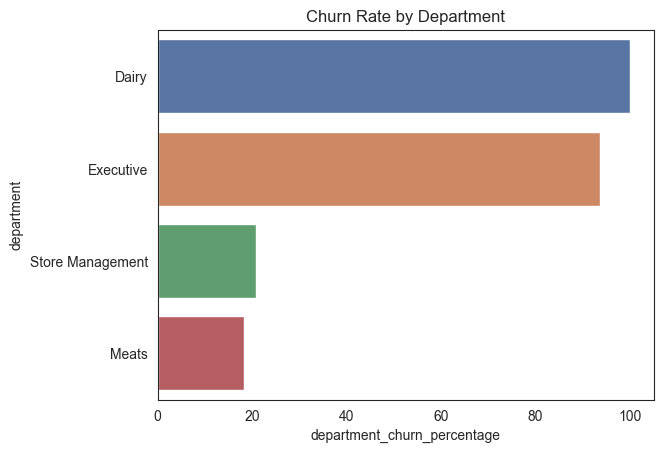

In [37]:
sns.barplot(
    data=churn_df,
    y='department',
    x='department_churn_percentage',
    hue= 'department',
    palette='deep',
    errorbar=None
)
plt.title('Churn Rate by Department')
plt.show()


____________________

## 2. Tenure vs Churn (Pandas)
- Which stores have the highest proportion of short, medium, and long tenure employees, and how does tenure relate to overall churn?


### Analysis

In [5]:
# Helper Function to maps years_employed into tenure categories
def map_tenure_category(years: int) -> str:
    if years < 2:
        return 'Short'
    elif 2 <= years <= 5:
        return 'Medium'
    return 'Long'

In [9]:
# Copy to preserve original dataframe
tenure_copy: pd.DataFrame = df.copy()

# Filter for needed columns 
tenure_df: pd.DataFrame = tenure_copy.filter(items=['employee_id', 'employee_status', 'years_employed', 'store_id' ])

# Map employees into tenure categories
tenure_df['tenure_category'] = tenure_df['years_employed'].apply(map_tenure_category)

# Count total number of employees in each tenure_category per store
total_employees_by_tenure_df = (
    tenure_df
    .groupby(['store_id', 'tenure_category'])
    .agg(all_employees=('employee_id', 'nunique'))
    .reset_index()
)

# Count number of terminated employees in each tenure_category per store
terminated_employees_by_tenure_df = (
    tenure_df
    .query("employee_status == 'TERMINATED'")
    .groupby(['store_id', 'tenure_category'])
    .agg(terminated_employees=('employee_id', 'nunique'))
    .reset_index()
)

# Merge employee dataframes
tenure_churn_df: pd.DataFrame = (
    total_employees_by_tenure_df
    .merge(terminated_employees_by_tenure_df, on=['store_id', 'tenure_category'], how='left').fillna(0)
    .assign(
        tenure_category=lambda df: pd.Categorical(      # Convert tenure_category to an ordered categorical so i can sort in order of Short, Medium, Long
            df['tenure_category'],
            categories=['Short', 'Medium', 'Long'],
            ordered=True
        ),
        
        # Cast to int, pandas upcasts column to float because missing values (NaN) are floats and column had NaNs
        terminated_employees= lambda df: df['terminated_employees'].astype(int), 

        # Add column for total employees per store
        total_employees_per_store = lambda df: ( 
            df
            .groupby('store_id')
            ['all_employees'].transform('sum')
        ),

        # Calculate percent of each tenure category per store: (total employees in category) / (total employees in store)
        tenure_percent_per_store = lambda df: ((df['all_employees'] / df['total_employees_per_store']) * 100).round(2),

        # Calculate churn rate per tenure category per store: (terminated employees in category) / (total employees in category).
        category_churn_rate = lambda df: ((df['terminated_employees'] / df['all_employees']) * 100).round(2)
    )
    .sort_values(['store_id', 'tenure_category'])
    .reset_index(drop=True)
)


tenure_churn_df.head()

,store_id,tenure_category,all_employees,terminated_employees,total_employees_per_store,tenure_percent_per_store,category_churn_rate
0,1,Short,36,2,157,22.93,5.56
1,1,Medium,50,2,157,31.85,4.00
2,1,Long,71,14,157,45.22,19.72
3,2,Short,26,1,108,24.07,3.85
4,2,Medium,30,0,108,27.78,0.00


### Visuals

In [66]:
# Create pivot table 
pivot_df = tenure_churn_df.pivot_table(
    index='store_id',               # make store_id the row labels
    columns='tenure_category',      # make tenure categories the column headers
    values='all_employees',         # what goes inside the table (the numbers)
    aggfunc='sum',                  # if there are multiple rows, sum them up
    observed=False
)

pivot_df.head()

tenure_category,Short,Medium,Long
store_id,,,
1,36,50,71
2,26,30,52
3,8,10,12
4,0,1,1
5,96,130,205


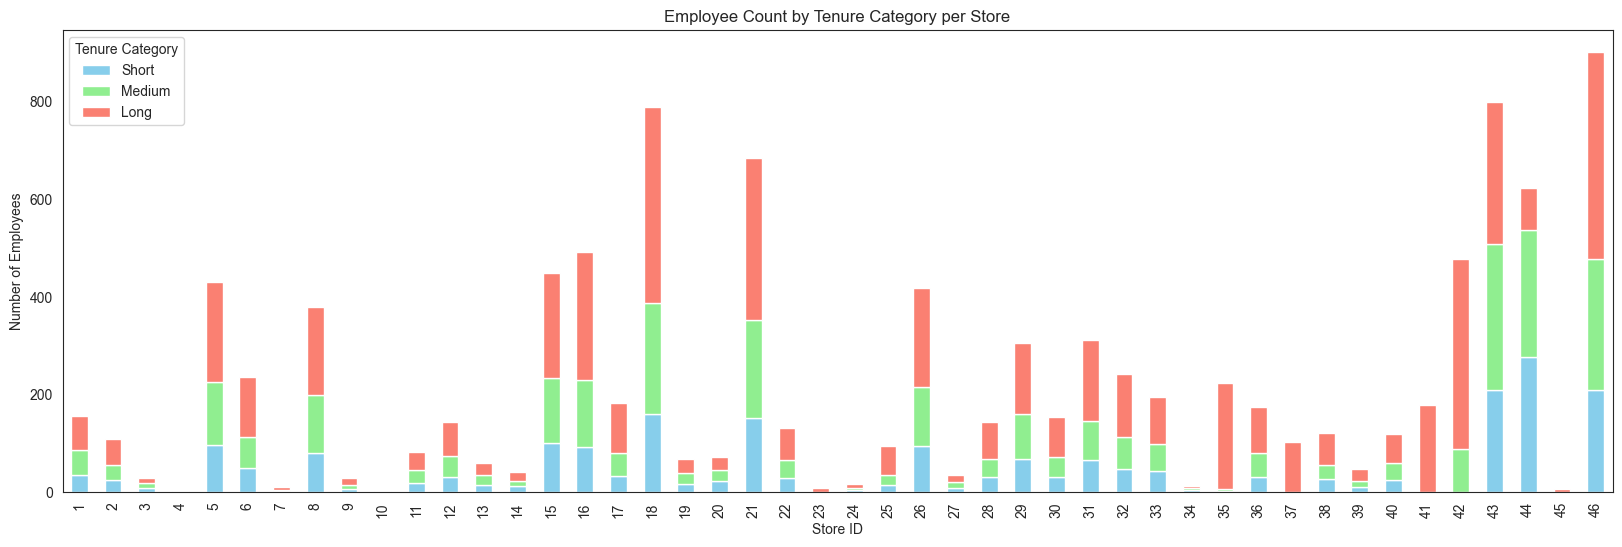

In [67]:
# Plot a stacked bar chart
pivot_df.plot(
    kind='bar',        # Tells pandas to make a bar chart (one bar per store)
    stacked=True,      # Stack Short + Medium + Long on top of each other
    figsize=(20, 6),   # Size of the whole figure (20 inches wide, 6 inches tall)
    color={            # Map each category to a fixed color
        'Short': 'skyblue',
        'Medium': 'lightgreen',
        'Long': 'salmon'
    }
)

plt.title('Employee Count by Tenure Category per Store') 
plt.xlabel('Store ID') 
plt.ylabel('Number of Employees') 
plt.legend(title='Tenure Category') 
plt.show()

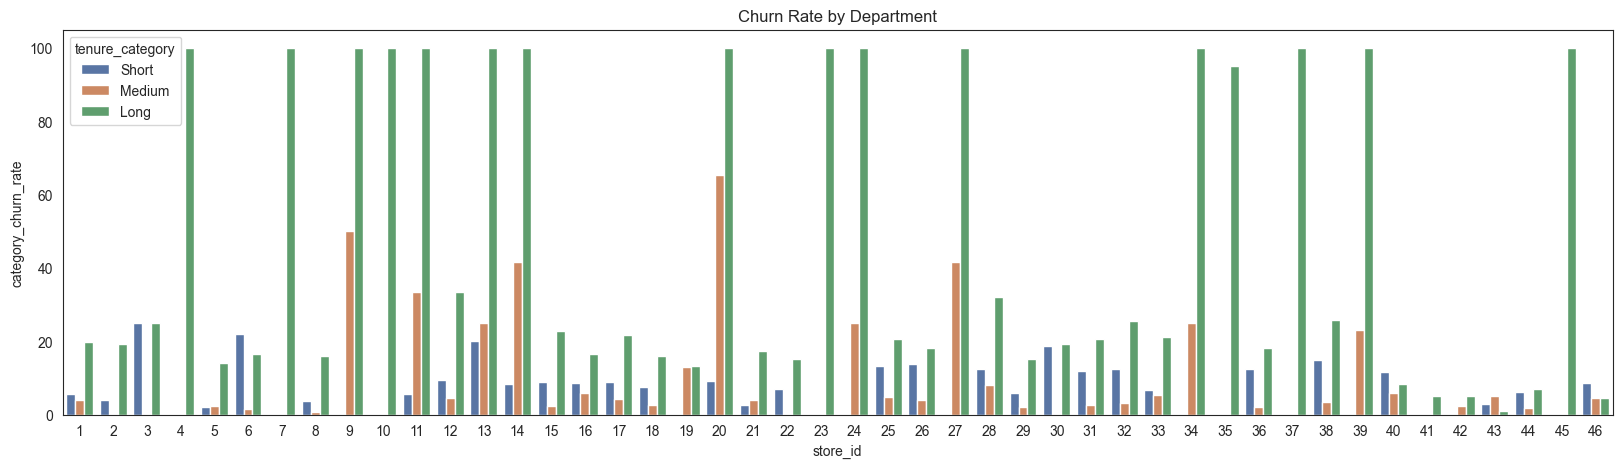

In [75]:
# Define chart size
plt.figure(figsize=(20,5))  

# Create bar chart
sns.barplot(
    data=tenure_churn_df,
    x='store_id',
    y='category_churn_rate',
    hue= 'tenure_category',
    palette='deep',
    errorbar=None
)
plt.title('Churn Rate by Department')
plt.show()


____________________

## 3. Churn By Demographics
- Which gender shows higher churn rates per store?

### Analysis

In [39]:
# Copy to preserve original dataframe
gender_copy: pd.DataFrame = df.copy()

# Filter for needed columns
gender_df: pd.DataFrame = gender_copy.filter(items=['employee_id', 'gender', 'employee_status', 'store_id'])

# Count total employees per gender
total_gender_df: pd.DataFrame = (
    gender_df
    .drop_duplicates()
    .groupby(['store_id', 'gender'])
    .agg(total_count = ('employee_id', 'count'))
    .reset_index()
)

# Count total terminated employees per gender
terminated_gender_df: pd.DataFrame = (
    gender_df
    .query("employee_status == 'TERMINATED'")
    .drop_duplicates()
    .groupby(['store_id', 'gender'])
    .agg(terminated_count = ('employee_id', 'count'))
    .reset_index()
)

# Merge both dataframes
gender_churn_df: pd.DataFrame = total_gender_df.merge(terminated_gender_df, on=['store_id', 'gender'], how='left').fillna(0)

# Calculate churn rate per gender per store 
gender_churn_df['churn_rate'] = ((gender_churn_df['terminated_count'] / gender_churn_df['total_count']) * 100).round(2)

gender_churn_df.head()





,store_id,gender,total_count,terminated_count,churn_rate
0,1,Female,57,16,28.07
1,1,Male,47,2,4.26
2,2,Female,41,10,24.39
3,2,Male,34,1,2.94
4,3,Female,14,3,21.43


### Visual - Bar Chart

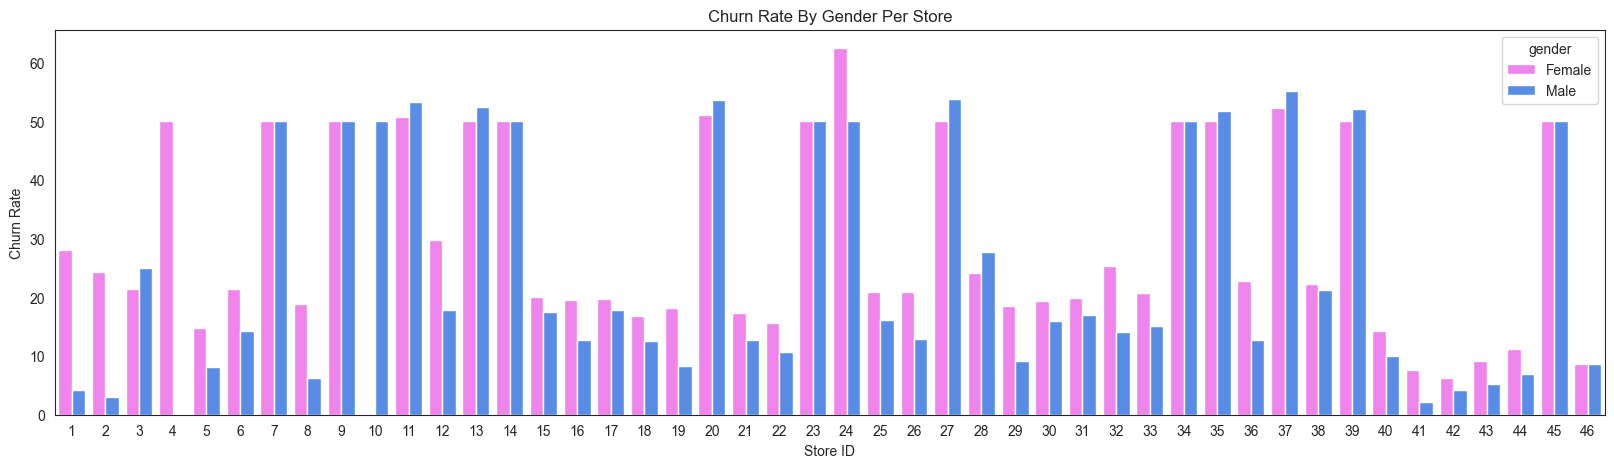

In [63]:

plt.figure(figsize=(20,5))  

color_palette: dict = {
    'Male': "#4287FC",  
    'Female': "#FF73FD"      
}

sns.barplot(
    data=gender_churn_df,
    x='store_id',
    y='churn_rate',
    hue= 'gender',
    palette=color_palette,
    errorbar=None
)

plt.title('Churn Rate By Gender Per Store')
plt.xlabel('Store ID')
plt.ylabel('Churn Rate')
plt.show()